In [1]:
!wget -O dataset.zip "https://physionet.org/content/noneeg/get-zip/1.0.0/"


--2025-07-31 23:45:48--  https://physionet.org/content/noneeg/get-zip/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3925168 (3.7M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   3.74M   615KB/s    in 6.2s    

2025-07-31 23:45:55 (614 KB/s) - ‘dataset.zip’ saved [3925168/3925168]



In [2]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [3]:
!unzip /content/dataset.zip -d dataset

Archive:  /content/dataset.zip
 extracting: dataset/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject6_AccTempEDA.dat  
 extracting: dataset/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject19_AccTempEDA.atr  
 extracting: dataset/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject17_SpO2HR.dat  
 extracting: dataset/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject12_SpO2HR.dat  
 extracting: dataset/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject13_SpO2HR.dat  
 extracting: dataset/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject3_SpO2HR.hea  
 extracting: dataset/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject6_AccTempEDA.hea  
 extracting: dataset/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject1_SpO2HR.dat  
 extracting: dataset/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/Subject14_AccTempEDA.atr  
 extracting: dataset/

In [4]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from scipy.signal import savgol_filter





Read WFDB signal files for each subject.

Apply Savitzky-Golay filter to smooth noisy signals.

Label the first half of samples as 'calm' and the second half as 'stress'.

Extract statistical features like mean, min, max

Prepare features and labels for machine learning models.

In [5]:
import os
import wfdb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.signal import savgol_filter

#segmented the data and performed feature engineering on every window of a column
def extract_features(df, window=1000):
    features, labels = [], []
    for i in range(0, len(df) - window, window):
        segment = df.iloc[i:i + window]
        feat = segment.drop(columns=['label', 'subject_id']).agg(['mean', 'std', 'min', 'max']).values.flatten()
        features.append(feat)
        labels.append(segment['label'].mode()[0])
    return features, labels

#combined 2 data files and performed signal smoothing
def load_all_subjects(data_path, num_subjects=20):
    X_all, y_all = [], []
    all_dfs = []

    for subject_id in range(1, num_subjects + 1):
        sid = f"Subject{subject_id}"
        try:
            rec_eda = wfdb.rdrecord(os.path.join(data_path, f"{sid}_AccTempEDA"))
            rec_hr = wfdb.rdrecord(os.path.join(data_path, f"{sid}_SpO2HR"))

            df_eda = pd.DataFrame(rec_eda.p_signal, columns=rec_eda.sig_name)
            df_hr = pd.DataFrame(rec_hr.p_signal, columns=rec_hr.sig_name)

            df = pd.concat([df_eda, df_hr], axis=1)

            for col in ['EDA', 'SpO2', 'HR', 'TEMP', 'ax', 'ay', 'az']:
                if col in df.columns:
                    df[col] = savgol_filter(df[col], window_length=51, polyorder=3)

            df['label'] = ['calm' if i < len(df) // 2 else 'stress' for i in range(len(df))]
            df['subject_id'] = subject_id

            feats, labs = extract_features(df)
            X_all.extend(feats)
            y_all.extend(labs)

            all_dfs.append(df)

        except Exception as e:
            print(f"[Error] {sid}: {e}")

    X_df = pd.DataFrame(X_all)
    X_df['label'] = y_all
    y_series = pd.Series(y_all)
    combined_df = pd.concat(all_dfs, ignore_index=True)
    return X_df, y_series, combined_df

data_path = "/content/dataset/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0"
X_df, y_series, all_data_df = load_all_subjects(data_path)

print(X_df.head())


          0         1         2          3         4          5          6  \
0  0.446106 -0.964941 -0.096645  30.798137  0.084657  96.176489  84.742234   
1  0.168963 -1.046222 -0.110009  31.666621  0.087063  95.732573  80.948363   
2  0.349908 -0.680132 -0.612089  32.197376  0.091568  95.112159  77.518786   
3  0.418686 -0.430457 -0.946235  32.573159  0.104032        NaN        NaN   
4  0.718978 -0.456044 -0.778823  32.578159  0.176230        NaN        NaN   

          7         8         9  ...         19         20        21  \
0  0.290516  0.077170  0.010564  ...  94.807892  66.000336  0.762895   
1  0.028319  0.001598  0.003504  ...  94.272867  72.000366  0.246935   
2  0.111533  0.302774  0.416216  ...  93.975904  71.000671  0.587356   
3  0.041156  0.091890  0.122424  ...        NaN        NaN  0.548201   
4  0.126579  0.040525  0.088597  ...        NaN        NaN  0.868399   

         22        23         24        25         26          27  label  
0 -0.867499 -0.051180  

          0         1         2          3         4          5          6  \
0  0.446106 -0.964941 -0.096645  30.798137  0.084657  96.176489  84.742234   
1  0.168963 -1.046222 -0.110009  31.666621  0.087063  95.732573  80.948363   
2  0.349908 -0.680132 -0.612089  32.197376  0.091568  95.112159  77.518786   
3  0.418686 -0.430457 -0.946235  32.573159  0.104032        NaN        NaN   
4  0.718978 -0.456044 -0.778823  32.578159  0.176230        NaN        NaN   

          7         8         9  ...         19         20        21  \
0  0.290516  0.077170  0.010564  ...  94.807892  66.000336  0.762895   
1  0.028319  0.001598  0.003504  ...  94.272867  72.000366  0.246935   
2  0.111533  0.302774  0.416216  ...  93.975904  71.000671  0.587356   
3  0.041156  0.091890  0.122424  ...        NaN        NaN  0.548201   
4  0.126579  0.040525  0.088597  ...        NaN        NaN  0.868399   

         22        23         24        25         26          27  label  
0 -0.867499 -0.051180  

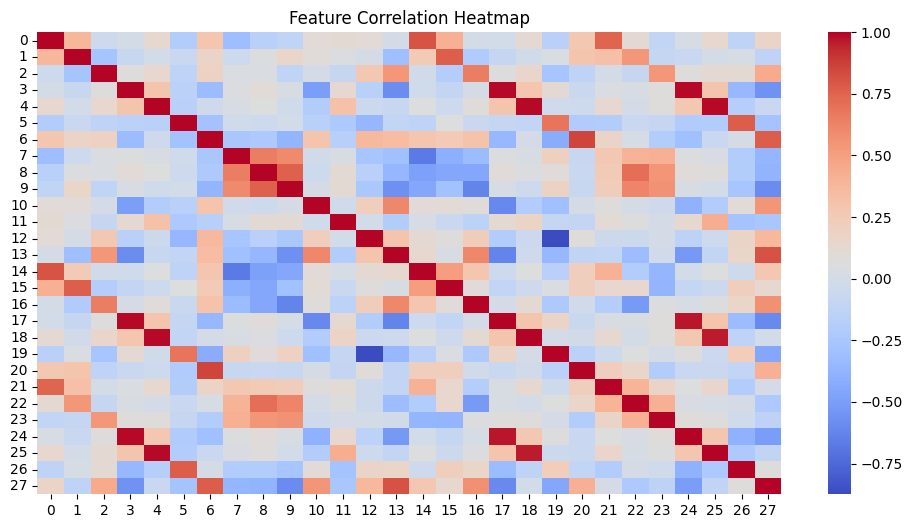

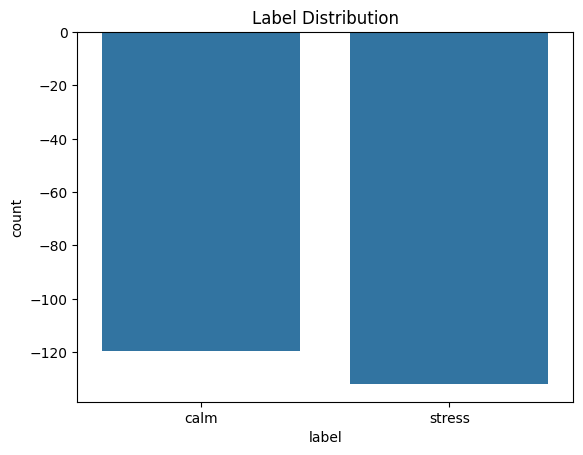

In [6]:
X_df['label'] = y_series

print(X_df.head())
print(X_df['label'].value_counts())

plt.figure(figsize=(12, 6))
sns.heatmap(X_df.drop('label', axis=1).corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

sns.countplot(x='label', data=X_df)
plt.title("Label Distribution")
plt.show()

In [24]:
X_df.isnull().sum()



,0
0,0
1,0
2,0
3,0
4,0
5,304
6,304
7,0
8,0
9,0


Visualizing data

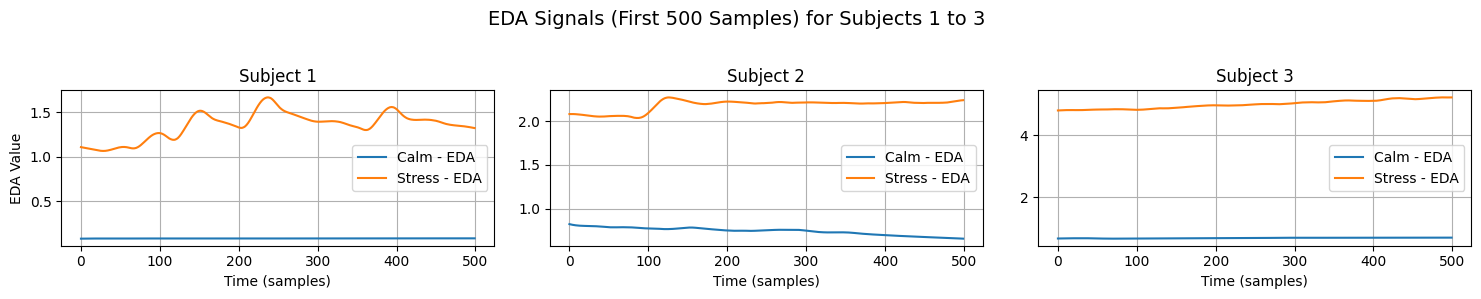

In [11]:
import matplotlib.pyplot as plt

# Create a horizontal row of 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))  # width x height

for idx, subject_id in enumerate(range(1, 4)):
    subject_data = all_data_df[all_data_df['subject_id'] == subject_id]

    calm_sub = subject_data[subject_data['label'] == 'calm']
    stress_sub = subject_data[subject_data['label'] == 'stress']

    ax = axes[idx]
    ax.plot(calm_sub['EDA'][:500].reset_index(drop=True), label='Calm - EDA')
    ax.plot(stress_sub['EDA'][:500].reset_index(drop=True), label='Stress - EDA')
    ax.set_title(f"Subject {subject_id}")
    ax.set_xlabel("Time (samples)")
    if idx == 0:
        ax.set_ylabel("EDA Value")
    ax.legend()
    ax.grid(True)

plt.suptitle("EDA Signals (First 500 Samples) for Subjects 1 to 3", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


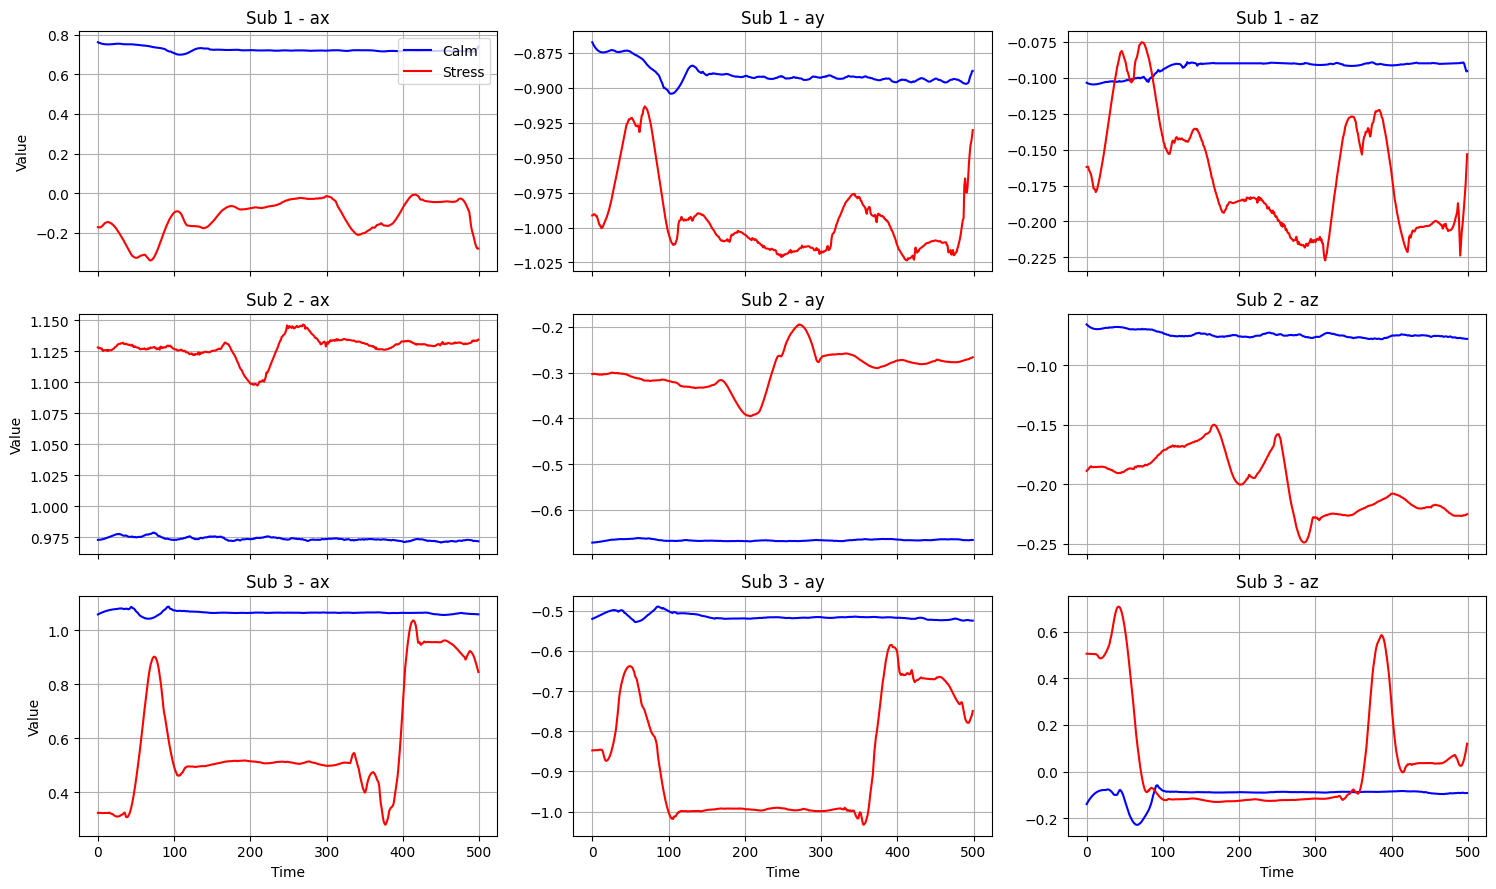

In [12]:
import matplotlib.pyplot as plt
import numpy as np

subject_ids = all_data_df['subject_id'].unique()[0:3]
axes = ['ax', 'ay', 'az']

fig, axs = plt.subplots(len(subject_ids), len(axes), figsize=(15, len(subject_ids)*3), sharex=True)

for i, subject_id in enumerate(subject_ids):
    subject_df = all_data_df[all_data_df['subject_id'] == subject_id]
    calm_sub = subject_df[subject_df['label'] == 'calm']
    stress_sub = subject_df[subject_df['label'] == 'stress']

    for j, axis in enumerate(axes):
        ax = axs[i, j] if len(subject_ids) > 1 else axs[j]
        ax.plot(calm_sub[axis][:500].reset_index(drop=True), label='Calm', color='blue')
        ax.plot(stress_sub[axis][:500].reset_index(drop=True), label='Stress', color='red')
        ax.set_title(f"Sub {subject_id} - {axis}")
        ax.grid(True)

        if i == len(subject_ids)-1:
            ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel("Value")

# Add legend to the first subplot only
axs[0, 0].legend(loc='upper right')
plt.tight_layout()
plt.show()


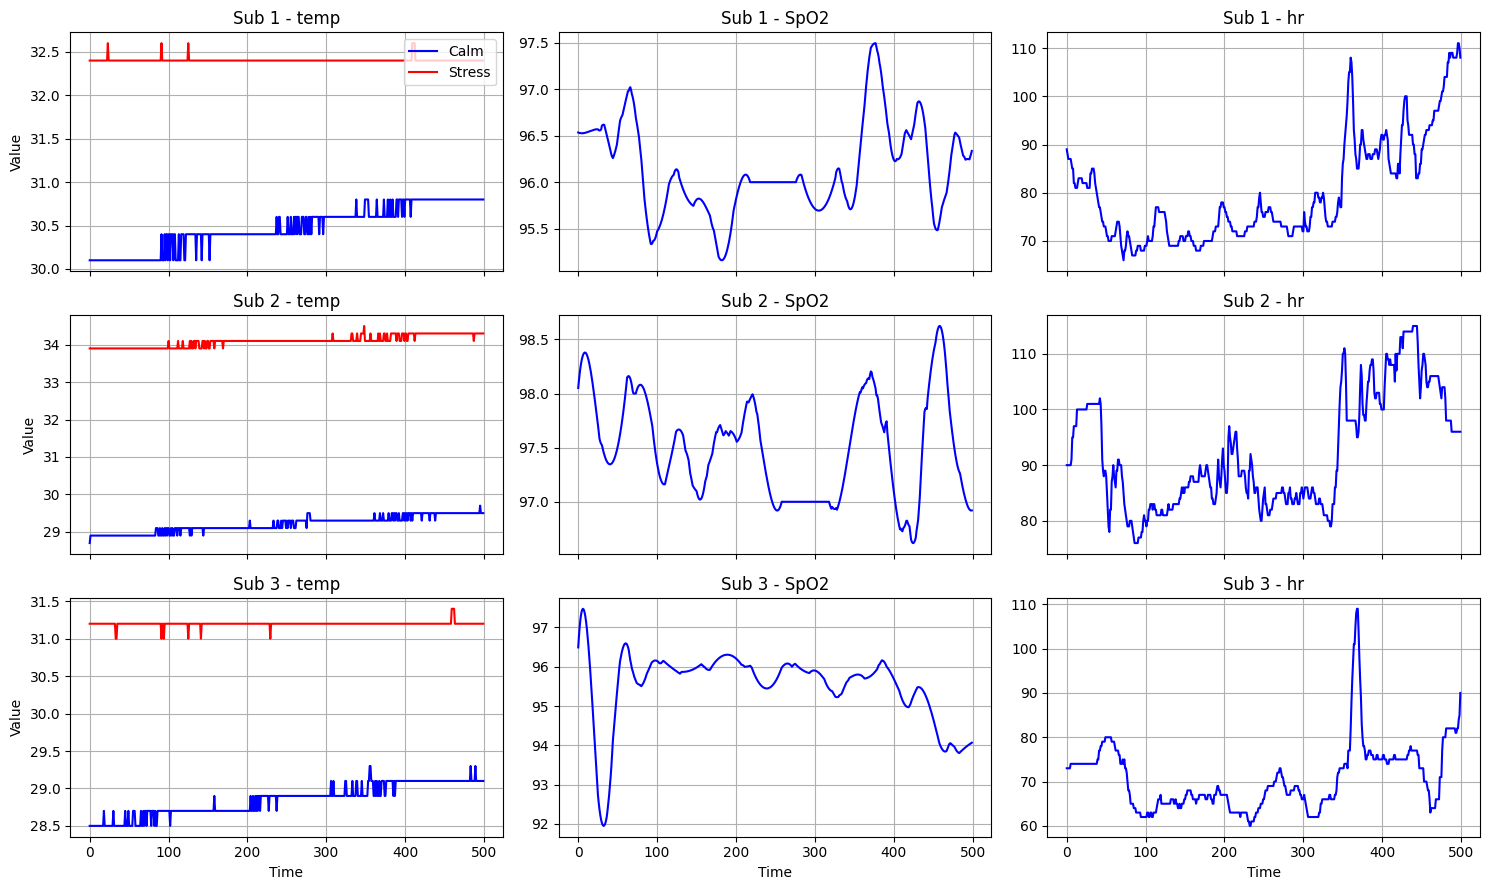

In [13]:
import matplotlib.pyplot as plt
import numpy as np

subject_ids = all_data_df['subject_id'].unique()[0:3]
axes = ['temp', 'SpO2', 'hr']

fig, axs = plt.subplots(len(subject_ids), len(axes), figsize=(15, len(subject_ids)*3), sharex=True)

for i, subject_id in enumerate(subject_ids):
    subject_df = all_data_df[all_data_df['subject_id'] == subject_id]
    calm_sub = subject_df[subject_df['label'] == 'calm']
    stress_sub = subject_df[subject_df['label'] == 'stress']

    for j, axis in enumerate(axes):
        ax = axs[i, j] if len(subject_ids) > 1 else axs[j]
        ax.plot(calm_sub[axis][:500].reset_index(drop=True), label='Calm', color='blue')
        ax.plot(stress_sub[axis][:500].reset_index(drop=True), label='Stress', color='red')
        ax.set_title(f"Sub {subject_id} - {axis}")
        ax.grid(True)

        if i == len(subject_ids)-1:
            ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel("Value")

# Add legend to the first subplot only
axs[0, 0].legend(loc='upper right')
plt.tight_layout()
plt.show()


Converted calm and stress into 0 and 1 ( label encoding )

Filled missing values with mean

Scaled the X data

In [14]:
le = LabelEncoder()
y_encoded = le.fit_transform(X_df['label'])
X = X_df.drop('label', axis=1)

X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
X.isnull().sum() # Counts missing values per column


,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


Trained a 1D CNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5324 - loss: 0.7090 - val_accuracy: 0.6575 - val_loss: 0.5894
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6444 - loss: 0.6197 - val_accuracy: 0.8493 - val_loss: 0.5331
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8033 - loss: 0.5298 - val_accuracy: 0.8219 - val_loss: 0.4558
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7617 - loss: 0.4969 - val_accuracy: 0.8493 - val_loss: 0.4366
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7837 - loss: 0.4501 - val_accuracy: 0.8082 - val_loss: 0.3921
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7780 - loss: 0.4339 - val_accuracy: 0.8493 - val_loss: 0.4058
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8301 - loss: 0.3907 - val_accuracy: 0.8356 - val_loss: 0.3928
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8229 - loss: 0.4168 - val_accuracy: 0.8219 - v

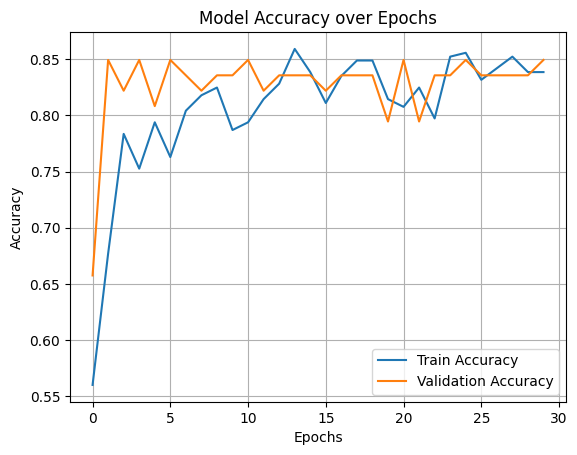

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')  # Adjust based on # of classes
])



model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_cnn, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_cnn, y_test)
)


loss, accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Comparing with other models

In [16]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n Model: {name}")
    print("Accuracy:", acc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    results[name] = acc


 Model: Random Forest
Accuracy: 0.7808219178082192
Classification Report:
              precision    recall  f1-score   support

        calm       0.81      0.81      0.81        42
      stress       0.74      0.74      0.74        31

    accuracy                           0.78        73
   macro avg       0.78      0.78      0.78        73
weighted avg       0.78      0.78      0.78        73


 Model: SVM (RBF)
Accuracy: 0.8082191780821918
Classification Report:
              precision    recall  f1-score   support

        calm       0.89      0.76      0.82        42
      stress       0.73      0.87      0.79        31

    accuracy                           0.81        73
   macro avg       0.81      0.82      0.81        73
weighted avg       0.82      0.81      0.81        73


 Model: KNN
Accuracy: 0.7808219178082192
Classification Report:
              precision    recall  f1-score   support

        calm       0.84      0.76      0.80        42
      stress       0.71   

Used Hyper parameter tuning to get best accuracies

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

best_results = {}
results_log = {}

# Random Forest
rf_n_estimators = [50, 100, 150]
rf_max_depth = [None, 10, 20, 30]
rf_min_samples_split = [2, 5]
rf_min_samples_leaf = [1, 2]

best_acc = 0
for n in rf_n_estimators:
    for d in rf_max_depth:
        for split in rf_min_samples_split:
            for leaf in rf_min_samples_leaf:
                model = RandomForestClassifier(
                    n_estimators=n,
                    max_depth=d,
                    min_samples_split=split,
                    min_samples_leaf=leaf,
                    random_state=42
                )
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                acc = accuracy_score(y_test, y_pred)
                label = f"RF | n={n}, depth={d}, split={split}, leaf={leaf}"
                results_log[label] = acc
                if acc > best_acc:
                    best_acc = acc
                    best_results["Random Forest"] = {
                        "accuracy": acc,
                        "n_estimators": n,
                        "max_depth": d,
                        "min_samples_split": split,
                        "min_samples_leaf": leaf
                    }

# SVM (RBF)
svm_C = [0.1, 1, 10]
svm_gamma = ['scale', 'auto']
svm_kernel = ['rbf', 'poly']
svm_degree = [2, 3]  # only relevant if kernel='poly'

best_acc = 0
for C in svm_C:
    for gamma in svm_gamma:
        for kernel in svm_kernel:
            for degree in (svm_degree if kernel == 'poly' else [3]):
                model = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, probability=True)
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                acc = accuracy_score(y_test, y_pred)
                label = f"SVM | C={C}, gamma={gamma}, kernel={kernel}, degree={degree}"
                results_log[label] = acc
                if acc > best_acc:
                    best_acc = acc
                    best_results["SVM (RBF)"] = {
                        "accuracy": acc,
                        "C": C,
                        "gamma": gamma,
                        "kernel": kernel,
                        "degree": degree
                    }

# KNN
knn_neighbors = [3, 5, 7]
knn_weights = ['uniform', 'distance']
knn_algorithms = ['auto', 'ball_tree', 'kd_tree']
knn_p = [1, 2]  # p=1: Manhattan, p=2: Euclidean

best_acc = 0
for k in knn_neighbors:
    for w in knn_weights:
        for algo in knn_algorithms:
            for p in knn_p:
                model = KNeighborsClassifier(n_neighbors=k, weights=w, algorithm=algo, p=p)
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                acc = accuracy_score(y_test, y_pred)
                label = f"KNN | k={k}, weights={w}, algo={algo}, p={p}"
                results_log[label] = acc
                if acc > best_acc:
                    best_acc = acc
                    best_results["KNN"] = {
                        "accuracy": acc,
                        "n_neighbors": k,
                        "weights": w,
                        "algorithm": algo,
                        "p": p
                    }

# Logistic Regression
lr_C = [0.01, 0.1, 1, 10]
lr_solver = ['liblinear', 'lbfgs', 'saga']
lr_penalty = ['l2']
lr_max_iter = [1000, 2000]

best_acc = 0
for C in lr_C:
    for solver in lr_solver:
        for penalty in lr_penalty:
            for max_iter in lr_max_iter:
                if solver == 'lbfgs' and penalty != 'l2':
                    continue
                try:
                    model = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=max_iter)
                    model.fit(X_train_scaled, y_train)
                    y_pred = model.predict(X_test_scaled)
                    acc = accuracy_score(y_test, y_pred)
                    label = f"LR | C={C}, solver={solver}, penalty={penalty}, max_iter={max_iter}"
                    results_log[label] = acc
                    if acc > best_acc:
                        best_acc = acc
                        best_results["Logistic Regression"] = {
                            "accuracy": acc,
                            "C": C,
                            "solver": solver,
                            "penalty": penalty,
                            "max_iter": max_iter
                        }
                except Exception as e:
                    print(f"Skipping invalid config: {label}. Reason: {e}")

# Final best hyperparameters
print("\n📌 Best Hyperparameters per Model:")
for model_name, details in best_results.items():
    print(f"\n🔹 {model_name}")
    for k, v in details.items():
        print(f"   {k}: {v}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



📌 Best Hyperparameters per Model:

🔹 Random Forest
   accuracy: 0.8356164383561644
   n_estimators: 50
   max_depth: None
   min_samples_split: 2
   min_samples_leaf: 1

🔹 SVM (RBF)
   accuracy: 0.8493150684931506
   C: 10
   gamma: scale
   kernel: rbf
   degree: 3

🔹 KNN
   accuracy: 0.8082191780821918
   n_neighbors: 5
   weights: distance
   algorithm: auto
   p: 1

🔹 Logistic Regression
   accuracy: 0.863013698630137
   C: 1
   solver: liblinear
   penalty: l2
   max_iter: 1000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
